In [38]:
import os
import sys
import warnings
from dataclasses import dataclass
from typing import Any
#from __future__ import annotations

import numpy as np
import pandas as pd
import matplotlib
matplotlib.rc('font', family='Noto Sans CJK JP')
import seaborn as sns
import matplotlib.pyplot as plt
import random
import warnings
warnings.simplefilter("ignore")

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [18]:
def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)


def regression_metrics(estimator, X, y):
    y_pred = estimator.predict(X)
    df = pd.DataFrame(
        data={
            "RMSE": [mean_squared_error(y, y_pred, squared=False)],
            "R2": [r2_score(y, y_pred)]
        }
    )
    return df

@dataclass
class PartialDependence:
    estimator: Any
    X: np.ndarray
    var_names: list

    def _counterfactual_prediction(self, idx_to_replace: int, value_to_replace: float) -> np.ndarray:
        # 特徴量の値を置き換える際、元データが上書きされないようコピー
        X_replaced = self.X.copy()

        # 特徴量の値を置き換えて予測
        X_replaced[:, idx_to_replace] = value_to_replace
        y_pred = self.estimator.predict(X_replaced)

        return y_pred

    def partial_dependence(self, var_name: str, n_grid: int = 50) -> None:
        # 可視化の際に用いるのでターゲットの変数名を保存
        self.target_var_name = var_name
        # 変数名に対応するインデックスをもってくる
        var_index = self.var_names.index(var_name)

        # ターゲットの変数を、取りうる値の最大値から最小値まで動かせるようにする
        value_range = np.linspace(
            self.X[:, var_index].min(),
            self.X[:, var_index].max(),
            num=n_grid
        )

        # インスタンスごとのモデルの予測値を平均
        average_prediction = np.array([
            self._counterfactual_prediction(var_index, x).mean()
            for x in value_range
        ])

        # データフレームとしてまとめる
        self.df_partial_dependence = pd.DataFrame(
            data={var_name: value_range, "avg_pred": average_prediction}
        )

    def plot(self, ylim) -> None:
        fig, ax = plt.subplots()
        ax.plot(
            self.df_partial_dependence[self.target_var_name],
            self.df_partial_dependence["avg_pred"],
        )
        ax.set(
            xlabel=self.target_var_name,
            ylabel="Average Prediction",
            ylim=ylim
        )
        fig.suptitle(f"Partial Dependence Plot ({self.target_var_name})")

        fig.show()

seed_everything()

In [7]:
def generate_simulation_data():
    N = 1000
    x0 = np.random.uniform(-1, 1, N)
    x1 = np.random.uniform(-1, 1, N)
    x2 = np.random.binomial(1, 0.5, N)
    epsilon = np.random.normal(0, 0.1, N)

    X = np.column_stack((x0, x1, x2))

    y = x0 - 5 * x1 + 10 * x1 * x2 + epsilon

    return train_test_split(X, y, test_size=0.2, random_state=42)

train_x, test_x, train_y, test_y = generate_simulation_data()

/home/kengo-fujii/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  import sys


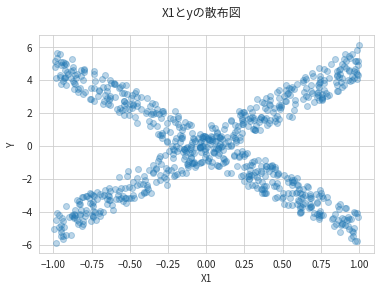

In [8]:
def plot_scatter(x, y, title=None, xlabel=None, ylabel=None):
    fig, ax = plt.subplots()
    ax.scatter(x, y, alpha=.3)
    ax.set(xlabel=xlabel, ylabel=ylabel)
    fig.suptitle(title)

    fig.show()

plot_scatter(train_x[:, 1], train_y, title="X1とyの散布図", xlabel="X1", ylabel="Y")

In [11]:
rf = RandomForestRegressor(n_jobs=-1, random_state=42).fit(train_x, train_y)
regression_metrics(rf, test_x, test_y)

,RMSE,R2
0,0.311734,0.989384


/home/kengo-fujii/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:70: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


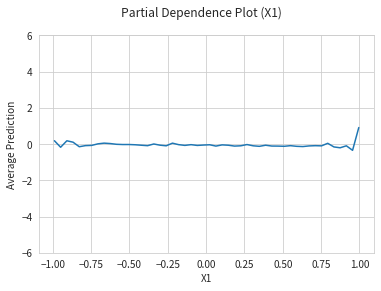

In [20]:
pdp = PartialDependence(rf, test_x, ["X0", "X1", "X2"])
pdp.partial_dependence("X1")
pdp.plot(ylim=(-6, 6))

In [32]:
class IndividualConditionalExpectation(PartialDependence):
    def individual_conditional_expectation(self, var_name, ids_to_compute, n_grid=50):
        self.target_var_name = var_name
        var_index = self.var_names.index(var_name)
        value_range = np.linspace(
            self.X[:, var_index].min(),
            self.X[:, var_index].max(),
            num = n_grid
        )
        individual_prediction = np.array([
            self._counterfactual_prediction(var_index, x)[ids_to_compute] for x in value_range
        ])

        self.df_ice = (
            pd.DataFrame(data=individual_prediction, columns=ids_to_compute).assign(**{var_name: value_range}).melt(id_vars=var_name, var_name="instance", value_name="ice")
        )

        self.df_instance = (
            pd.DataFrame(
                data=self.X[ids_to_compute],
                columns=self.var_names
            ).assign(
                instance=ids_to_compute,
                prediction=self.estimator.predict(self.X[ids_to_compute])
            ).loc[:, ["instance", "prediction"] + self.var_names]
        )

    def plot(self, ylim):
        fig, ax = plt.subplots()
        sns.lineplot(
            self.target_var_name,
            "ice",
            units="instance",
            data=self.df_ice,
            lw=.8,
            alpha=.5,
            estimator=None,
            zorder=1,
            ax=ax
        )

        sns.scatterplot(
            self.target_var_name,
            "prediction",
            data=self.df_instance,
            zorder=2,
            ax=ax
        )
        ax.set(xlabel=self.target_var_name, ylabel="Prediction", ylim=ylim)
        fig.suptitle(
            f"Individual Conditional Expectation({self.target_var_name})"
        )

        plt.show()

In [36]:
ice = IndividualConditionalExpectation(rf, test_x, ["X0", "X1", "X2"])
ice.individual_conditional_expectation("X1", [0])
ice.df_instance

,instance,prediction,X0,X1,X2
0,0,-3.739563,-0.238218,0.868872,0.0


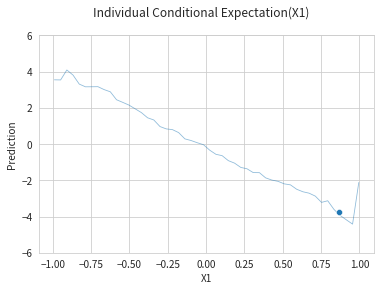

In [39]:
ice.plot(ylim=(-6,6))

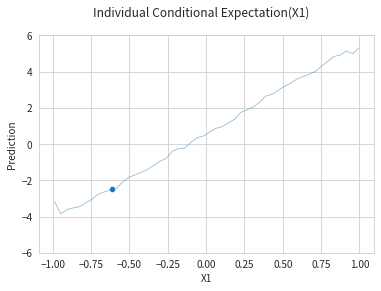

In [40]:
ice.individual_conditional_expectation("X1", [1])
ice.plot(ylim=(-6,6))

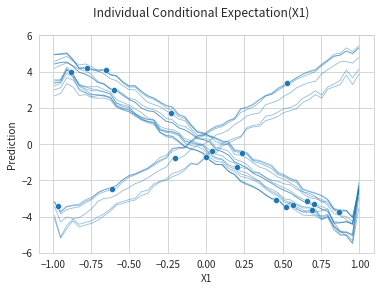

In [41]:
ice.individual_conditional_expectation("X1", range(20))
ice.plot(ylim=(-6,6))

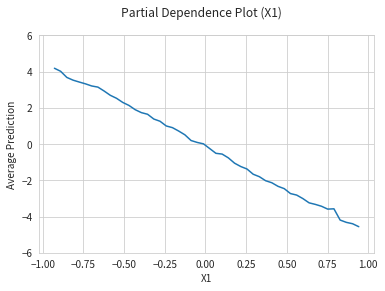

In [43]:
pdp = PartialDependence(rf, test_x[test_x[:,2]==0], ["X0", "X1", "X2"])
pdp.partial_dependence("X1")
pdp.plot(ylim=(-6,6))

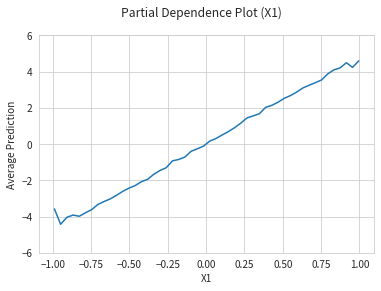

In [44]:
pdp = PartialDependence(rf, test_x[test_x[:, 2]==1], ["X0", "X1", "X2"])
pdp.partial_dependence("X1")
pdp.plot(ylim=(-6, 6))

In [47]:
# 実データ
from sklearn.datasets import load_boston
from sklearn.inspection import partial_dependence

boston = load_boston()

X = pd.DataFrame(data=boston["data"], columns=boston["feature_names"])
y = boston["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)
rf = RandomForestRegressor(n_jobs=-1, random_state=42)

rf.fit(X_train, y_train)

ice = partial_dependence(
    estimator=rf,
    X=X_test,
    features=["RM"],
    kind="both"
)
ice

{'average': array([[18.85780392, 18.78220588, 18.77509804, 18.74723529, 18.53620588,
         18.68498039, 18.68963725, 18.70292157, 18.70666667, 18.70652941,
         18.7077451 , 18.70991176, 18.7099902 , 18.71266667, 18.69570588,
         18.78512745, 18.78676471, 18.73911765, 18.8157451 , 18.8157451 ,
         18.81963725, 19.13511765, 19.1480098 , 19.29561765, 19.28178431,
         19.29342157, 19.30133333, 19.29657843, 19.29454902, 19.29820588,
         19.305     , 19.31521569, 19.34894118, 19.34862745, 19.35315686,
         19.3725    , 19.3785098 , 19.37987255, 19.37911765, 19.37547059,
         19.35468627, 19.35060784, 19.34788235, 19.33320588, 19.48998039,
         19.49003922, 20.05187255, 20.08277451, 20.16319608, 20.18614706,
         20.1855098 , 20.18246078, 20.18193137, 20.18560784, 20.18733333,
         20.18686275, 20.19282353, 20.18408824, 20.21892157, 20.2259902 ,
         20.27601961, 20.27448039, 20.28603922, 20.32848039, 20.33937255,
         20.35803922, 20.32

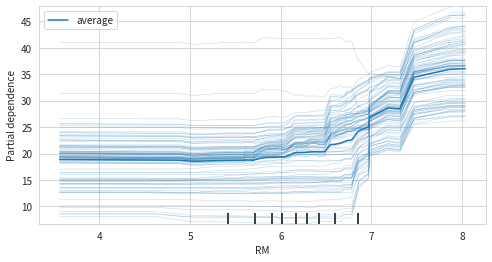

In [48]:
from sklearn.inspection import plot_partial_dependence
def plot_ice():
    fig, ax = plt.subplots(figsize=(8,4))
    plot_partial_dependence(
        estimator=rf,
        X=X_test,
        features=["RM"],
        kind="both",
        ax=ax
    )
    fig.show()


plot_ice()